## Analysis of 'Spotify App Reviews 2022' from Google Play Store

In [1]:
import time
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


simplefilter(action='ignore', category=FutureWarning)

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

rev_df = pd.read_csv('reviews.csv')
rev_df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


Firstly I will clean up the dataset from two columns which are useless for this analyse
and not necessary such as 'Time_submitted' and 'Reply' which mostly contained NaNs.
Secondly I will remove punctuation from all reviews and later explain what which column means.

In [2]:
rev_df = rev_df.drop(columns=['Time_submitted', 'Reply'], axis=1)
rev_df.Review = rev_df.apply(lambda record : remove_punctuation(record['Review']), axis=1)

rev_df.head()

,Review,Rating,Total_thumbsup
0,Great music service the audio is high quality ...,5,2
1,Please ignore previous negative rating This ap...,5,1
2,This popup Get the best Spotify experience on ...,4,0
3,Really buggy and terrible to use as of recently,1,1
4,Dear Spotify why do I get songs that I didnt p...,1,1


`Review` - review text

`Rating` - given score between 1 and 5

`Total_thumbsup` - how many people find this review as helpful

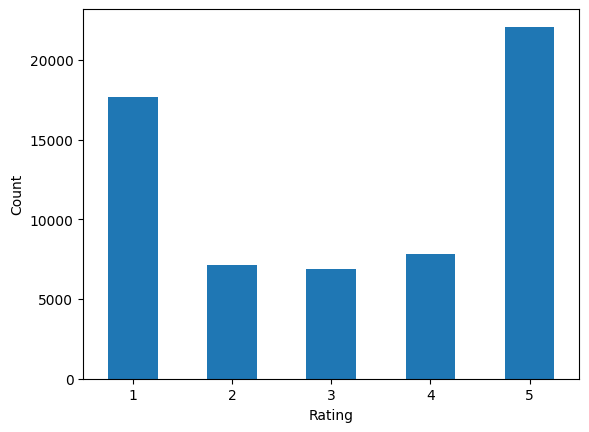

In [3]:
help_df = rev_df['Rating'].value_counts()
help_df = help_df.sort_index()
help_df.plot(kind='bar', xlabel='Rating', ylabel='Count', rot=0)
plt.show()

As we can see on the chart above we can say that amount of 2 and 4 are similar
also 1 and 5s are pretty similar and the rating 3 is used the least times, so
we will assume that reviews with rating 3 are our reviews with neutral sentiment.

In [4]:
before = sum(rev_df.Rating == 3)
rev_df = rev_df[rev_df.Rating != 3]
after = sum(rev_df.Rating == 3)
#short test
print("Rows with 'Rating' score 3:", before)
print("Rows with 'Rating' score 3:", after)

Rows with 'Rating' score 3: 6886
Rows with 'Rating' score 3: 0


We removed records with rating 3 and assigned it our rev_df dataset.

In [5]:
rev_df.loc[rev_df.Rating <= 2, 'Rating'] = -1
rev_df.loc[rev_df.Rating >= 4, 'Rating'] = 1

to_limited_df = rev_df.copy()

#short test:
sum(rev_df["Rating"]**2 != 1)

0

We assigned values which were 'negative' so 1 and 2 to value -1, and the 'positive' ones
such as 4 and 5 to 1.

In [6]:
review_train, review_test, rating_train, rating_test = train_test_split(rev_df.Review, rev_df.Rating)

vectorizer = CountVectorizer()

vector_review_train = vectorizer.fit_transform(list(review_train))
vector_review_test = vectorizer.transform(list(review_test))

Next we use CountVectorizer() which is tool used to transform a given text into a vector of numbers.
Transformation is based on frequency of each word that figure in the text.

In [7]:
model = LogisticRegression(solver='lbfgs', max_iter=1500)
model.fit(vector_review_train, rating_train)

LogisticRegression(max_iter=1500)

We are creating model by using Logistic Regression which is used to predict the probability of a binary event figuring.
To avoid warnings (which are not meaningful, only makes output worse looking) I'm using solver and max_iter.

In [8]:
words = list(zip(model.coef_[0], vectorizer.get_feature_names()))
sorted_words = sorted(words, key=lambda x: x[0])

most_positive_words = [word[1] for word in sorted_words[-10:]]
most_negative_words = [word[1] for word in sorted_words[:10]]

print('Most positive words:', most_positive_words)
print('Most negative words:', most_negative_words)

Most positive words: ['1010', 'brilliant', 'love', 'easy', 'wonderful', 'amazing', 'best', 'awesome', 'loving', 'excellent']
Most negative words: ['misinformation', 'worst', 'trash', 'horrible', 'rubbish', 'pointless', 'disappointing', 'greedy', 'garbage', 'pathetic']


By using functions model.coef_, vectorizer.get_feature_names() and few more we
are creating list of 10 most positive and negative words.

In [9]:
begin = time.time()
predictions = model.predict(vector_review_test)
predictions_time_to_do = time.time() - begin
print(predictions_time_to_do * 1000, 's')

1.6031265258789062 s


We are using .predict() function to predict the labels of the data values based
on our trained model. We also use function time from time library to save time
of evaluation for later to compare with limited dictionary.

In [10]:
probability_predictions = model.predict_proba(vector_review_test)
print(probability_predictions)

[[0.0398737  0.9601263 ]
 [0.75306325 0.24693675]
 [0.2510072  0.7489928 ]
 ...
 [0.34682315 0.65317685]
 [0.99032622 0.00967378]
 [0.89091215 0.10908785]]


By using model.predict_proba() function we are getting in return array which
contains lists with class probabilities for the given data.

In [11]:
reviews = list(zip(probability_predictions, review_test))
sorted_reviews = sorted(reviews, key=lambda x: x[0][1])

most_positive_reviews = [review[1] for review in sorted_reviews[-5:]]
most_negative_reviews = [review[1] for review in sorted_reviews[:5]]

print('The most positive reviews:')
for x, review in enumerate(most_positive_reviews):
    print(f'{x+1}. {review}')

print('\nThe most negative reviews:')
for x, review in enumerate(most_negative_reviews):
    print(f'{x+1}. {review}')

The most positive reviews:
1. Ive been a premium subscriber since around April 2019 and have been very happy with the app Ive found spotify to be an excellent experience across all my devices My only reason to give them 4 stars and not 5 comes down solely to the fact that I dont yet have lyrics available on my phone but Ill certainly change it to a 5 once thats cleared up one day Thank you for the excellent experience so far Spotify Some lyrics would be nice though😉
2. Theres such variety and available music that you can enjoy tremendous amounts of diversity I love that Old and new artists its wonderful Music to relax music to work out with music to inspire music to motivate Spotify is fantastic I like that I can share with my Husband too I also like that wherever I utilize Spotify my playlists remain as I make them coolreally happy with Spotify
3. I love Spotify and I love how open Joe Rogan is As a Black man just a man btw I find him and his many guests to be delightful There are gue

Here we created list of 5 most positive and negative reviews.

In [12]:
predictions_accuracy_score = accuracy_score(rating_test, predictions)
print('Accuracy of predictions equals:', predictions_accuracy_score)

Accuracy of predictions equals: 0.8850625137091468


Accuracy_score function returns value of our prediction accuracy, which is
about 88.7% which for this data is pretty good result.

In [13]:
significant_words = ['love','great','easy','old','little','perfect','loves','well','able','car','broke','less','even','waste','disappointed','work','product','money','would','return']

ratings_train, ratings_test, reviews_train, reviews_test = train_test_split(to_limited_df.Rating, to_limited_df.Review)

vectorizer = CountVectorizer(vocabulary=significant_words)
vector_train_rev = vectorizer.fit_transform(list(reviews_train))
vector_test_rev = vectorizer.transform(list(reviews_test))

model = LogisticRegression()
model.fit(vector_train_rev, ratings_train)

words = list(zip(model.coef_[0], vectorizer.get_feature_names()))
sorted_words = sorted(words, key=lambda x: x[0])

most_positive_words = [word[1] for word in sorted_words[:10]]
most_negative_words = [word[1] for word in sorted_words[-10:]]

print('Most positive words:', most_positive_words)
print('Most negative words:', most_negative_words)

begin = time.time()
predictions_small = model.predict(vector_test_rev)
predictions_small_time_to_do = time.time() - begin

probability_predictions = model.predict_proba(vector_test_rev)

reviews = list(zip(probability_predictions, reviews_test))
sorted_reviews = sorted(reviews, key=lambda x: x[0][1])

most_positive_reviews = [review[1] for review in sorted_reviews[:5]]
most_negative_reviews = [review[1] for review in sorted_reviews[-5:]]

print('The most positive reviews:')
for x, review in enumerate(most_positive_reviews):
    print(f'{x+1}. {review}')

print('\nThe most negative reviews:')
for x, review in enumerate(most_negative_reviews):
    print(f'{x+1}. {review}')

predictions_small_accuracy_score = accuracy_score(ratings_test, predictions_small)
print('\nAccuracy of predictions equals:', predictions_small_accuracy_score)


accuracy_all = predictions_accuracy_score * 100
accuracy_limited = predictions_small_accuracy_score * 100
accuracy_diff = accuracy_all - accuracy_limited
accuracy_diff_x = accuracy_all / accuracy_limited
time_all = predictions_time_to_do * 1000
time_limited = predictions_small_time_to_do * 1000
time_diff = (time_all - time_limited)
time_diff_x = time_all / time_limited

t = PrettyTable(['', 'Dictionary with all words', 'Dictionary with limited words', 'All words difference with limited dictionary by'])
t.add_row(['Accuracy', f'{accuracy_all:.2f}%', f'{accuracy_limited:.2f}%', f'{accuracy_diff:.2f}% / {accuracy_diff_x:.2f}x'])
t.add_row(['Time of evaluation', f'{time_all:.2f}ms', f'{time_limited:.2f}ms', f'{time_diff:.2f}ms / {time_diff_x:.2f}x'])
print(t)

Most positive words: ['waste', 'broke', 'even', 'disappointed', 'money', 'car', 'work', 'product', 'return', 'able']
Most negative words: ['would', 'less', 'old', 'well', 'little', 'loves', 'great', 'perfect', 'love', 'easy']
The most positive reviews:
1. I very rarely leave reviews and if I do theyre almost never negative but I feel compelled in this instance as the Spotify app has got to be the worst app I have ever used Im on pay as you go with no Internet access unless Im on WiFi and all I use this app for is to listen to podcasts which I download in full before my work commute Its obvious it simply has not been designed with any consideration for a user like myself I would go as far as to state that its terrible for podcasts in general regardless of how you use your phone To give you some examples 1 When Im at work my phone will connect to the work WiFi Theres an internal authorisation process to let devices use Internet when on the company network What happens is that I cant play

Here we are doing the same things as we made in previous cells but just
changing some things to make it all suitable for smaller dictionary. As we can
see we are getting much worse accuracy of predictions than we got
previously for bigger dictionary. The time of evaluation was only slightly
different but accuracy dropped nearly 25%. In limited dictionary some 'positive'
reviews in fact.

Maybe our vocabulary was bad and that is cause of bad results.

# Now lets jump to other types of classifiers and try them.

## DecisionTreeClassifier

The decision tree algorithm creates a node for every attribute in a dataset,
with the most crucial attribute being placed at the top node. To evaluate, we
begin at the top node and navigate through the tree by selecting the
appropriate node that satisfies our condition. This continues until we reach a
final node, known as a leaf node, which holds the prediction or result of the
decision tree.

In [14]:
tree_model = DecisionTreeClassifier()

tree_model.fit(vector_review_train, rating_train)

begin = time.time()
tree_predictions = tree_model.predict(vector_review_test)
tree_predictions_time_to_do = time.time() - begin
print(tree_predictions_time_to_do * 1000, 's')

tree_predictions_accuracy_score = accuracy_score(tree_predictions, rating_test)
print('Accuracy of predictions equals:', tree_predictions_accuracy_score)

4.776954650878906 s
Accuracy of predictions equals: 0.7947649338305184


## SupportVectorClassifier

Algorithm creates a boundary or a hyperplane between different classes in the
dataset, with the goal of maximizing the margin between the classes. This
boundary is chosen in such a way that it maximally separates the different
classes while also minimizing the misclassification errors. The training data
points that are closest to the boundary are known as support vectors, and the
algorithm uses these points to form the decision boundary.

In [15]:
svc_model = svm.SVC()

svc_model.fit(vector_review_train, rating_train)

begin = time.time()
svc_predictions = svc_model.predict(vector_review_test)
svc_predictions_time_to_do = time.time() - begin
print(svc_predictions_time_to_do * 1000, 's')

svc_predictions_accuracy_score = accuracy_score(svc_predictions, rating_test)
print('Accuracy of predictions equals:', svc_predictions_accuracy_score)

36669.88492012024 s
Accuracy of predictions equals: 0.8861592454485633


## KNNClassifier

The K-nearest Neighbors algorithm is a supervised learning method that can be
used for classification, regression, and identifying outliers. It is a simple
algorithm to implement, yet can accomplish advanced tasks. Additionally, it is
known as a "lazy" algorithm since it does not require a separate training
phase.

In [16]:
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(vector_review_train, rating_train)

begin = time.time()
knn_predictions = knn_model.predict(vector_review_test)
knn_predictions_time_to_do = time.time() - begin
print(knn_predictions_time_to_do * 1000, 's')

knn_predictions_accuracy_score = accuracy_score(knn_predictions, rating_test)
print('Accuracy of predictions equals:', knn_predictions_accuracy_score)

20544.881105422974 s
Accuracy of predictions equals: 0.7100241280982672


Now lets compare these classifiers used with CountVectorizer()

In [17]:
t = PrettyTable(['', 'Accuracy', 'Time of evaulation'])
t.add_row(['LogisticRegression', f'{predictions_accuracy_score * 100:.2f}%', f'{predictions_time_to_do:.5f}s'])
t.add_row(['DecisionTreeClassifier', f'{tree_predictions_accuracy_score * 100:.2f}%', f'{tree_predictions_time_to_do:.5f}s'])
t.add_row(['SupportVectorClassifier', f'{svc_predictions_accuracy_score * 100:.2f}%', f'{svc_predictions_time_to_do:.5f}s'])
t.add_row(['KNNClassifier', f'{knn_predictions_accuracy_score * 100:.2f}%', f'{knn_predictions_time_to_do:.5f}s'])
print(t)

+-------------------------+----------+--------------------+
|                         | Accuracy | Time of evaulation |
+-------------------------+----------+--------------------+
|    LogisticRegression   |  88.51%  |      0.00160s      |
|  DecisionTreeClassifier |  79.48%  |      0.00478s      |
| SupportVectorClassifier |  88.62%  |     36.66988s      |
|      KNNClassifier      |  71.00%  |     20.54488s      |
+-------------------------+----------+--------------------+


As we can see the best result we got with LogisticRegression and SupportVectorClassifier,
these two were pretty close to each other

Lets use TF-IDF Vectorizer instead of CountVectorizer and compare
LogisticRegression and DecisionTreeClassifier results with this vectorizer and
with CountVectorizer

In [18]:
vectorizer = TfidfVectorizer()

vector_review_train = vectorizer.fit_transform(review_train)
vector_review_test = vectorizer.transform(review_test)

In [19]:
model2 = LogisticRegression(solver='lbfgs', max_iter=1500)
model2.fit(vector_review_train, rating_train)

begin = time.time()
tf_predictions = model2.predict(vector_review_test)
tf_predictions_time_to_do = time.time() - begin
print(tf_predictions_time_to_do * 1000, 's')

tf_predictions_accuracy_score = accuracy_score(tf_predictions, rating_test)
print('Accuracy of predictions equals:', tf_predictions_accuracy_score)

1.0461807250976562 s
Accuracy of predictions equals: 0.8903999415076406


In [20]:
tf_tree_model = DecisionTreeClassifier()

tf_tree_model.fit(vector_review_train, rating_train)

begin = time.time()
tf_tree_predictions = tf_tree_model.predict(vector_review_test)
tf_tree_predictions_time_to_do = time.time() - begin
print(tree_predictions_time_to_do * 1000, 's')

tf_tree_predictions_accuracy_score = accuracy_score(tree_predictions, rating_test)
print('Accuracy of predictions equals:', tf_tree_predictions_accuracy_score)

t = PrettyTable(['', 'Accuracy', 'Time of evaulation'])
t.add_row(['LogisticRegression with CountVectorizer()', f'{predictions_accuracy_score * 100:.2f}%', f'{predictions_time_to_do:.5f}s'])
t.add_row(['LogisticRegression with TfidfVectorizer()', f'{tf_predictions_accuracy_score * 100:.2f}%', f'{tf_predictions_time_to_do:.5f}s'])
t.add_row(['DecisionTreeClassifier with CountVectorizer()', f'{tree_predictions_accuracy_score * 100:.2f}%', f'{tree_predictions_time_to_do:.5f}s'])
t.add_row(['DecisionTreeClassifier with TfidfVectorizer()', f'{tf_tree_predictions_accuracy_score * 100:.2f}%', f'{tf_tree_predictions_time_to_do:.5f}s'])

print(t)

4.776954650878906 s
Accuracy of predictions equals: 0.7947649338305184
+-----------------------------------------------+----------+--------------------+
|                                               | Accuracy | Time of evaulation |
+-----------------------------------------------+----------+--------------------+
|   LogisticRegression with CountVectorizer()   |  88.51%  |      0.00160s      |
|   LogisticRegression with TfidfVectorizer()   |  89.04%  |      0.00105s      |
| DecisionTreeClassifier with CountVectorizer() |  79.48%  |      0.00478s      |
| DecisionTreeClassifier with TfidfVectorizer() |  79.48%  |      0.00847s      |
+-----------------------------------------------+----------+--------------------+


As we can see in table shown above in both cases accuracy is similar (in
DecisionTreeClassifier even the same) but slightly better with TfidfVectorizer().